In [1]:
import cv2
import pytesseract
from PIL import Image
from paddleocr import PaddleOCR, LayoutDetection,TableCellsDetection
import json
import os
import sys

In [2]:
sys.path.append(os.path.abspath("../src"))

In [3]:
PADDLECLAS_PATH = os.path.abspath('/teamspace/studios/this_studio/PaddleClas/')

In [4]:
if not os.path.exists(PADDLECLAS_PATH):
    print(f"Error: PaddleClas path not found at '{PADDLECLAS_PATH}'")
    print("Please update the PADDLECLAS_PATH variable in your script.")
else:
    # Add the PaddleClas path to Python's search path
    if PADDLECLAS_PATH not in sys.path:
        sys.path.insert(0, PADDLECLAS_PATH)
        print(f"Added PaddleClas path to system: {PADDLECLAS_PATH}")

Added PaddleClas path to system: /teamspace/studios/this_studio/PaddleClas


In [5]:
from text_classifier import TextClassifier 

Error: Can not import paddle core while this file exists: /home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/paddle/base/libpaddle.so


ImportError: libcuda.so.1: cannot open shared object file: No such file or directory

In [203]:
from ppcls.utils import logger

In [204]:
logger.init_logger()

In [205]:
print("Loading all models...")
layout_model = LayoutDetection(model_name="PP-DocLayout_plus-L")
cell_model = TableCellsDetection(model_name="RT-DETR-L_wired_table_cell_det")
text_type_classifier = TextClassifier(
    config_path='/teamspace/studios/this_studio/PaddleOCR/models/classifier_model/my_text_classifier.yaml',
    model_weights_path='/teamspace/studios/this_studio/PaddleOCR/models/classifier_model/model.pdparams'
)
print("All models loaded successfully.")

Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /teamspace/studios/this_studio/.paddlex/official_models.


Loading all models...


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /teamspace/studios/this_studio/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Initializing Text Classifier...
[2025/06/24 12:25:16] ppcls WARNING: "init_res" will be deprecated, please use "init_net" instead.
Text Classifier initialized successfully.
All models loaded successfully.


In [206]:
image_path = "../Birth_Certificate/birth_certificate_18.jpg"

In [207]:
image_path2 = "./output/temp_table.png"

In [208]:
model = LayoutDetection(model_name="PP-DocLayout_plus-L")
output = model.predict(image_path, batch_size=1, layout_nms=True)
output_dict = output[0]

original_image = Image.open(image_path).convert("RGB")

all_result = []

for res in output:
    res.print()
    res.save_to_img(save_path="./output/")
    res.save_to_json(save_path="./output/res.json")

Using official model (PP-DocLayout_plus-L), the model files will be automatically downloaded and saved in /teamspace/studios/this_studio/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

{'res': {'input_path': '../Birth_Certificate/birth_certificate_18.jpg', 'page_index': None, 'boxes': [{'cls_id': 2, 'label': 'text', 'score': 0.7471510767936707, 'coordinate': [52.290215, 52.346962, 217.69704, 119.04224]}, {'cls_id': 6, 'label': 'figure_title', 'score': 0.7140572667121887, 'coordinate': [255.38548, 122.492195, 438.11667, 155.86305]}, {'cls_id': 8, 'label': 'table', 'score': 0.668876051902771, 'coordinate': [51.04738, 166.22456, 647.8714, 738.342]}]}}


In [209]:
output_table_path = "./output/temp_table.jpg"

In [210]:
from paddleocr import SealRecognition

In [211]:
import numpy as np

In [212]:
all_result = []

for comp in output_dict["boxes"]:
    label = comp['label']
    coords = [int(p) for p in comp["coordinate"]]
    region_img = original_image.crop(coords)
    region_img_np = np.array(region_img)
    # text_type = classify_handwritten_or_printed(region_img_np)
    
    if label == "table":
        table_crop_path = "./output/temp_table.jpg"
        region_img.save(table_crop_path)
        cell_model = TableCellsDetection(model_name="RT-DETR-L_wired_table_cell_det")
        cell_output = cell_model.predict(table_crop_path, threshold=0.3, batch_size=1)
        table_x1, table_y1, _, _ = coords  # Get top-left of table in original image
        for cell in cell_output[0]["boxes"]:
            x1, y1, x2, y2 = [int(p) for p in cell["coordinate"]]
            # Offset cell coordinates to original image
            abs_x1, abs_y1, abs_x2, abs_y2 = x1 + table_x1, y1 + table_y1, x2 + table_x1, y2 + table_y1
            cell_img = original_image.crop((abs_x1, abs_y1, abs_x2, abs_y2))
            cell_img_np = np.array(cell_img)
            cell_text_type = text_type_classifier.predict(cell_img_np)
            # if cell_text_type == "printed":
            #     text = pytesseract.image_to_string(cell_img_np, lang='khm', config='--oem 3 --psm 6').strip().replace('\f', '')
            # else:
            #     # For handwritten cells, you might want to use a different OCR model or settings
            #     text = ""
            text = pytesseract.image_to_string(cell_img_np, lang='khm', config='--oem 3 --psm 6').strip().replace('\f', '')
            all_result.append({
                "type": "table_cell",
                "parent_table_coords": coords,
                "cell_coords": [abs_x1, abs_y1, abs_x2, abs_y2],
                "text": text,
                "text_type": cell_text_type,
            })
        pass
    # elif label == "seal":
    #     seal_crop_path = "./output/temp_seal.jpg"
    #     region_img.save(seal_crop_path)
    #     pipeline = SealRecognition(
    #         use_doc_orientation_classify=False,
    #         use_doc_unwarping=False,
    #     )
    #     seal_output = pipeline.predict(seal_crop_path)
    #     # You can extract more info from seal_output if needed
    #     seal_text = ""
    #     if seal_output and hasattr(seal_output[0], "text"):
    #         seal_text = seal_output[0].text
    #     text = pytesseract.image_to_string(cell_img_np, lang='khm', config='--oem 3 --psm 6').strip().replace('\f', '')
    #     all_result.append({
    #         "type": "seal",
    #         "coords": coords,
    #         "text": seal_text,
    #     })
    else:
        # if text_type == "printed":
        #     # For printed text
        #     text = pytesseract.image_to_string(region_img_np, lang='khm', config='--oem 3 --psm 6').strip().replace('\f', '')
        # else:
        #     text = ""    
        # For seal and text
        # region_img_np = np.array(region_img)
        text_type = text_type_classifier.predict(cell_img_np)
        text = pytesseract.image_to_string(region_img_np, lang='khm', config='--oem 3 --psm 6').strip().replace('\f', '')
        all_result.append({
            "type": label,
            "coords": coords,
            "text": text,
            "text_type": text_type,
        })

# Save or visualize results
with open("./output/all_layout_results.json", "w", encoding="utf-8") as f:
    json.dump(all_result, f, ensure_ascii=False, indent=4)

print(f"Processed {len(all_result)} components (including table cells).")

Using official model (RT-DETR-L_wired_table_cell_det), the model files will be automatically downloaded and saved in /teamspace/studios/this_studio/.paddlex/official_models.


Fetching 6 files:   0%|          | 0/6 [00:00<?, ?it/s]

Processed 36 components (including table cells).


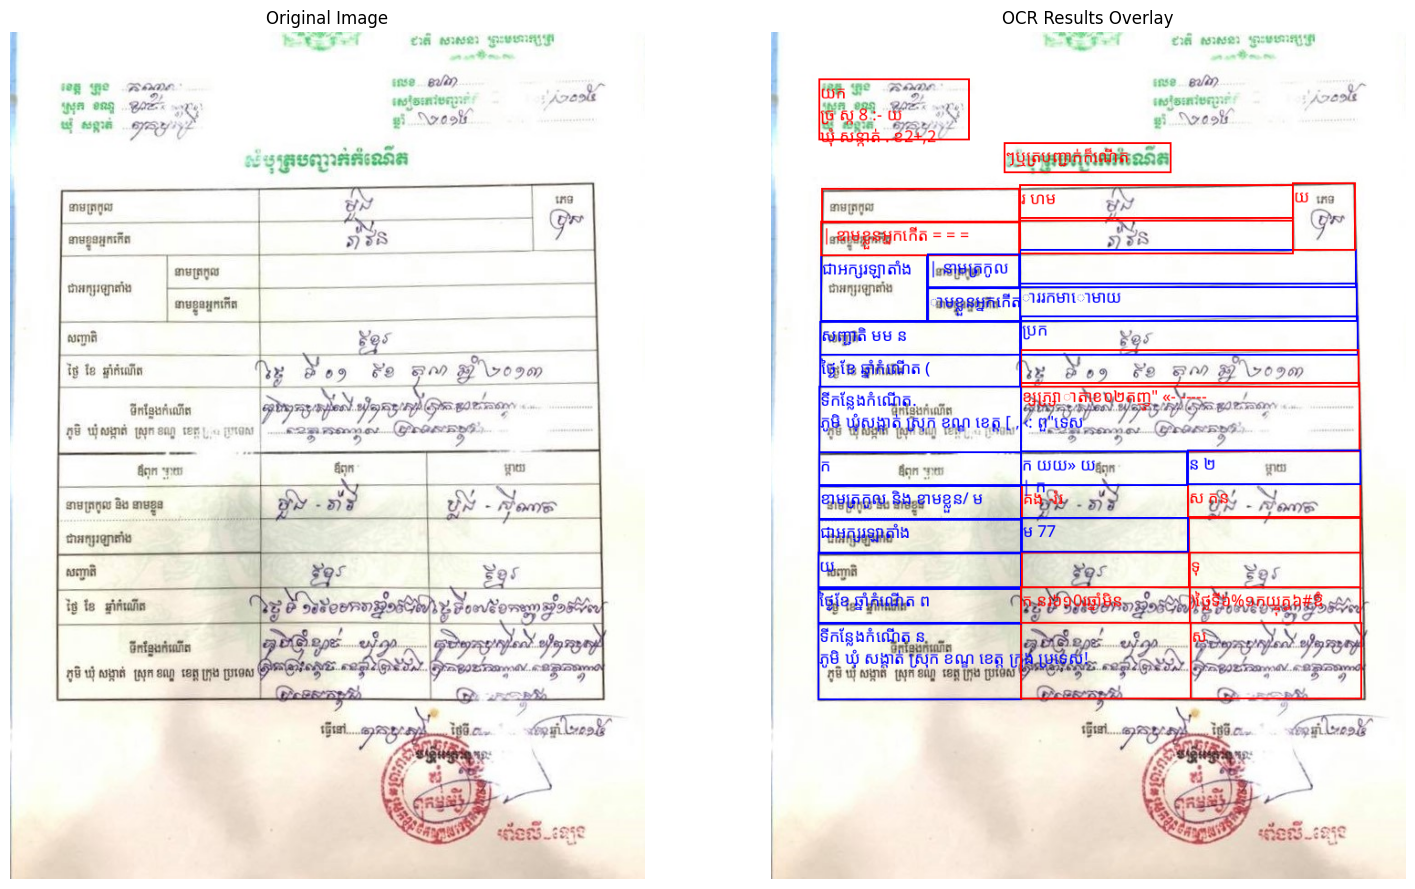

In [213]:
import json
from PIL import Image, ImageDraw, ImageFont
import matplotlib.pyplot as plt

# Load the original image
img = Image.open(image_path).convert("RGB")
img_annotated = img.copy()

# Load the OCR results
with open("./output/all_layout_results.json", "r", encoding="utf-8") as f:
    results = json.load(f)

# Prepare to draw on the annotated image
draw = ImageDraw.Draw(img_annotated)
try:
    # Use a Khmer font if available (put the .ttf file in your project folder)
    font = ImageFont.truetype("../NotoSansKhmer.ttf", 18)
except:
    font = ImageFont.load_default()

for item in results:
    if item.get("type") == "table_cell" and "cell_coords" in item:
        x1, y1, x2, y2 = item["cell_coords"]
        text_type = item.get("text_type", "unknown")
        if text_type == "handwritten":
            color = "red"
        elif text_type == "printed":
            color = "blue"
    elif "coords" in item:
        x1, y1, x2, y2 = item["coords"]
        text_type = item.get("text_type", "unknown")
        if text_type == "handwritten":
            color = "red"
        elif text_type == "printed":
            color = "blue"
        # color = "blue" if item.get("type") == "seal" else "green"
    else:
        continue
    draw.rectangle([x1, y1, x2, y2], outline=color, width=2)
    draw.text((x1+2, y1+2), item.get("text", ""), fill=color, font=font)

# Show side by side
plt.figure(figsize=(18, 12))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("OCR Results Overlay")
plt.imshow(img_annotated)
plt.axis("off")

img_annotated.save("./output/ocr_results_overlay.jpg")

plt.show()